In [3]:
# Import libraries
import pandas as pd
import numpy as np

In [29]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
# Load data from a csv file

df = pd.read_csv("/Users/olgakomissarova/Desktop/SalesData.csv", index_col=[0], parse_dates=[0])
df

,Value
DATE,
2010-01-01,72.5052
2010-02-01,70.6720
2010-03-01,62.4502
2010-04-01,57.4714
2010-05-01,55.3151
...,...
2023-05-01,78.0303
2023-06-01,86.4579
2023-07-01,93.8379


In [7]:
#
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Monthly Sales')

In [8]:
#Split 
split_date = '01-Jan-2020'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

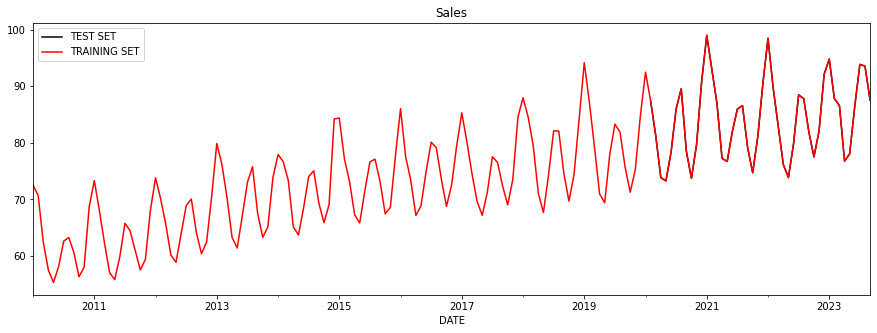

In [9]:
_ = df_test \
    .rename(columns={'Value': 'TEST SET'}) \
    .join(df.rename(columns={'Value': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Sales', kind= 'line', color=['black','red'])

In [10]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    
    X = df[['quarter','month','year']]
    if label:
        y = df[label]
        return X, y
    return X

In [11]:
X_train, y_train = create_features(df_train, label='Value')
X_test, y_test = create_features(df_test, label='Value')

In [12]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/Users/olgakomissarova/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       early_stopping_rounds=None, enable_categorical=False,
       eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
       importance_type=None, interaction_constraints='',
       learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
       max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
       missing=nan, monotone_constraints='()', n_estimators=1000, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', predictor='auto',
       random_state=0, reg_alpha=0, reg_lambda=1,
       sampling_method='uniform', scale_pos_weight=1, subsample=1,
       tree_method='exact', validate_parameters=1, verbosity=None)

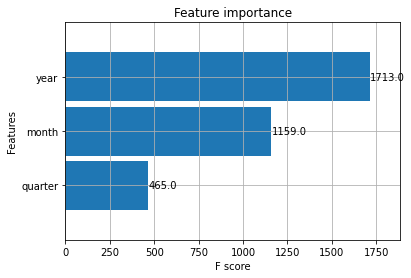

In [13]:
#Feature Importance
_ = plot_importance(reg, height=0.9)

In [14]:
#Forecast on test set

In [15]:
df_test['Sales_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

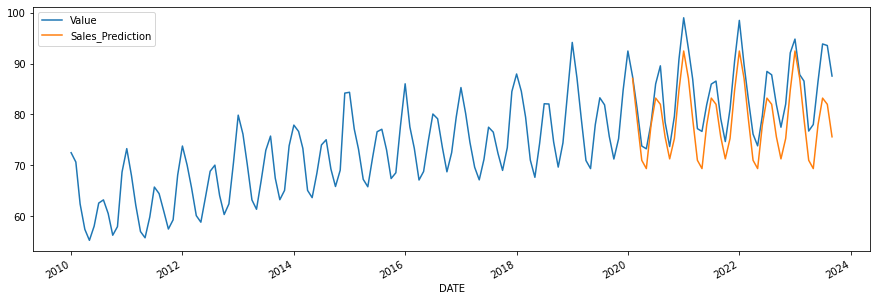

In [16]:
_ = df_all[['Value','Sales_Prediction']].plot(figsize=(15, 5))

In [17]:
#Error on test set

mean_squared_error(y_true=df_test['Value'],
                   y_pred=df_test['Sales_Prediction'])

34.08833586646445

In [18]:
mean_absolute_error(y_true=df_test['Value'],
                   y_pred=df_test['Sales_Prediction'])

5.179063848322087

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
mean_absolute_percentage_error(y_true=df_test['Value'],
                   y_pred=df_test['Sales_Prediction'])

6.116620633627535

In [21]:
#look at worst and best predicted months
df_test['error'] = df_test['Value'] - df_test['Sales_Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month']) \
    .mean()[['Value','Sales_Prediction','error','abs_error']]

In [22]:
# Over forecasted months
error_by_day.sort_values('error', ascending=True).head(10)

Value  Sales_Prediction     error  abs_error
year month                                                
2020 2      87.4033         87.074806  0.328494   0.328494
     6      78.3026         77.951942  0.350658   0.350658
2023 2      87.8200         87.074806  0.745194   0.745194
2022 6      79.7645         77.951942  1.812558   1.812558
2020 3      81.2661         79.151878  2.114222   2.114222
2023 1      94.7920         92.455421  2.336579   2.336579
2020 10     73.7066         71.295273  2.411327   2.411327
2022 2      89.7795         87.074806  2.704694   2.704694
2021 7      85.9606         83.214035  2.746565   2.746565
2020 7      85.9841         83.214035  2.770065   2.770065

In [23]:
# Worst predicted months
error_by_day.sort_values('abs_error', ascending=False).head(10)

Value  Sales_Prediction      error  abs_error
year month                                                 
2023 9      87.5414         75.623001  11.918399  11.918399
     8      93.5310         82.000366  11.530634  11.530634
     7      93.8379         83.214035  10.623865  10.623865
     5      78.0303         69.388741   8.641559   8.641559
     6      86.4579         77.951942   8.505958   8.505958
2021 3      86.9356         79.151878   7.783722   7.783722
2020 8      89.5467         82.000366   7.546334   7.546334
2023 3      86.5549         79.151878   7.403022   7.403022
2022 12     92.1010         84.777122   7.323878   7.323878
2021 5      76.6826         69.388741   7.293859   7.293859

In [24]:
# Best predicted months
error_by_day.sort_values('abs_error', ascending=True).head(10)

Value  Sales_Prediction     error  abs_error
year month                                                
2020 2      87.4033         87.074806  0.328494   0.328494
     6      78.3026         77.951942  0.350658   0.350658
2023 2      87.8200         87.074806  0.745194   0.745194
2022 6      79.7645         77.951942  1.812558   1.812558
2020 3      81.2661         79.151878  2.114222   2.114222
2023 1      94.7920         92.455421  2.336579   2.336579
2020 10     73.7066         71.295273  2.411327   2.411327
2022 2      89.7795         87.074806  2.704694   2.704694
2021 7      85.9606         83.214035  2.746565   2.746565
2020 7      85.9841         83.214035  2.770065   2.770065